In [117]:
import cv2
import numpy as np

In [118]:
def WarpImage_TPS(source, target, img):
    tps = cv2.createThinPlateSplineShapeTransformer()
        
    source=source.reshape(-1,len(source),2)
    target=target.reshape(-1,len(target),2)
    
    matches=list()
    
    for i in range(0,len(source[0])):
        matches.append(cv2.DMatch(i,i,0))
    
    matches = sorted(matches, key=lambda x: x.distance)

    tps.estimateTransformation(target, source, matches)
    new_img = tps.warpImage(img)
    
    return new_img, matches

In [127]:
# Example usage
img1 = cv2.imread('./data/osim.jpg')
mask = cv2.imread('./data/osim.png')
clothes = cv2.imread('./data/align_shirt.png')

clothes_gray = cv2.cvtColor(clothes, cv2.COLOR_BGR2GRAY)
clothes_mask = cv2.threshold(clothes_gray, 0, 255, cv2.THRESH_BINARY)[1]
cv2.imwrite('clothes_mask.png', clothes_mask)

mask_ = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask_contour, _ = cv2.findContours(mask_, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_contour = mask_contour[0]
mask_contour_sq = mask_contour.squeeze()

clothes_mask_contour, _ = cv2.findContours(clothes_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
clothes_mask_contour = clothes_mask_contour[0]
clothes_mask_contour_sq = clothes_mask_contour.squeeze()

cv2.drawContours(mask, mask_contour, -1, (0, 255, 0), 2)
cv2.drawContours(mask, clothes_mask_contour, -1, (0, 0, 255), 2)

# Align the images using TPS warping
img2_aligned, matches = WarpImage_TPS(mask_contour_sq, clothes_mask_contour_sq, clothes)

visualize_matches(mask, mask_contour_sq, clothes, clothes_mask_contour_sq, matches)

# Display the aligned image
cv2.imshow('mask contour', mask)
cv2.imshow('clothes mask contour', clothes)
cv2.imshow('Aligned Image', img2_aligned)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [131]:
clothes_mask_contour_sq.shape

(431, 2)

In [128]:
import random

def visualize_matches(img1, keypoints1, img2, keypoints2, matches):
    # Create a new image to display the matches
    height = max(img1.shape[0], img2.shape[0])
    width = img1.shape[1] + img2.shape[1]
    img_matches = np.zeros((height, width, 3), dtype=np.uint8)

    # Concatenate the two input images horizontally
    img_matches[:img1.shape[0], :img1.shape[1]] = img1
    img_matches[:img2.shape[0], img1.shape[1]:] = img2

    # Draw lines between the matching keypoints
    for match in matches:
        # Get the keypoints indices for the current match
        idx1 = match.queryIdx
        idx2 = match.trainIdx
        
        # Get the coordinates of the keypoints
        pt1 = tuple(map(int, keypoints1[idx1]))
        pt2 = tuple(map(int, keypoints2[idx2]))

        # Draw a line between the keypoints
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        cv2.line(img_matches, pt1, (pt2[0] + img1.shape[1], pt2[1]), (b, g, r), 1)

    # Display the image with the matching keypoints
    cv2.imshow('Matches', img_matches)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# TPS

In [122]:
import numpy as np
from scipy.spatial.distance import cdist


class TPS:
    def fit(self, source, target, reg=1e-3):
        '''
            source -> n x 2 array of source points.
            target -> n x 2 array of target points.
            reg -> regularization coefficient.
            return -> bending energy
        '''
        n = source.shape[0]
        K = TPS.U(cdist(source, source, 'sqeuclidean'))
        # regularaizing
        K += reg * np.eye(K.shape[0])
        P = np.concatenate((np.ones((n, 1)), source), axis=1)
        L = np.vstack([np.hstack([K, P]),
                       np.hstack([P.T, np.zeros((3, 3))])])
        Y = np.concatenate((target, np.zeros((3, 2))), axis=0)
        L_inv = np.linalg.inv(L)
        L_inv_Y = np.matmul(L_inv, Y)
        self.W = L_inv_Y
        self.source = source
        self.bending_energy = np.trace(np.matmul(np.matmul(self.W[:n, :].T, K), self.W[:n, :]))
        return self.bending_energy

    def transform(self, point):
        '''
            points -> 1 x 2 array representing (x, y).
            return -> 1 x 2 array of transformed point.
        '''
        dist = TPS.U(cdist(point, self.source, 'sqeuclidean'))
        tmp = np.array([[1, point[0, 0], point[0, 1]]])
        new_point = np.matmul(np.hstack([dist, tmp]), self.W)
        return new_point

    def U(dist):
        '''
            dist -> matrix of squared euclidean distance
                    between pairs.
            return -> [d * log(d)] elementwise on dist.
        '''
        ret = np.zeros_like(dist)
        mask = dist > 0
        ret[mask] = dist[mask] * np.log(dist[mask])
        return ret

# Shape Context

In [124]:
import math, cv2
import numpy as np
from scipy.optimize import linear_sum_assignment
# import tps

class Point:
    def __init__(self, x, y):
        self.x = float(x)
        self.y = float(y)

    def cart2logpolar(self):
        '''
            return (rho, theta)
        '''
        rho = math.sqrt(self.x * self.x + self.y * self.y)
        theta = math.atan2(self.x, self.y)
        return (math.log(rho), theta)

    def dist2(self, other):
        return (self.x - other.x)**2 + (self.y - other.y)**2

class Shape:
    def __init__(self, shape=None, img=None):
        '''
            shape -> 2d list of [[x1, y1], ...],
                     default shape is canny edges
            self.shape -> shape
            self.shape_pts -> list of Point instead of lists.
            self.shape_contexts -> list of [arrays -> shape_context]
        '''
        self.img = img
        if shape is None:
            shape = utils.canny_edge_shape(img)
        self.shape = shape
        self.shape_pts = []
        for point in shape:
            self.shape_pts.append(Point(point[0], point[1]))
        self.shape_contexts = self.get_shape_contexts()

    def get_shape_contexts(self, angular_bins=12, radious_bins=None):
        '''
            angular_bins -> number of bins for angle.
            radious_bins -> number of bins for radious,
                            default is maximum radious.
            return -> list of shape context in image (bin array)
        '''
        # get maximum number of radious_bins
        if radious_bins is None:
            max_dist2 = 0
            for i in range(len(self.shape_pts)):
                for j in range(len(self.shape_pts)):
                    max_dist2 = max(max_dist2, self.shape_pts[i].dist2(self.shape_pts[j]))
            radious_bins = int(math.log(math.sqrt(max_dist2))) + 1
        shape_contexts = [np.zeros((radious_bins, angular_bins), dtype=float) for _ in range(len(self.shape_pts))]
        # compute bins
        for i in range(len(self.shape_pts)):
            for j in range(len(self.shape_pts)):
                if i == j:
                    continue
                pt = Point(self.shape_pts[j].x - self.shape_pts[i].x,
                           self.shape_pts[j].y - self.shape_pts[i].y)
                r, theta = pt.cart2logpolar()
                if r < 0:
                    x = 0
                else:
                    x = int(r)
                if theta == math.pi:
                    y = angular_bins - 1
                else:
                    y = int(angular_bins * ((theta + math.pi) / (math.pi + math.pi)))
                shape_contexts[i][x][y] += 1
        return [shape_context.reshape((radious_bins * angular_bins)) for shape_context in shape_contexts]

    def get_cost_matrix(self, Q, beta=.1, robust=False, dummy_cost=1):
        '''
            Q -> instance of Shape
            beta -> coefficient of tangent_angle_dissimilarity,
                    1-beta is coefficient of shape_context_cost
            return -> (cost matrix for matching a points
                      from shape_context1 to shape_context2,
                      flag -> dummies added or not
                              cif not -> 0
                              if added to P -> -n
                              if added to Q -> m)
        '''
        def normalize_histogram(hist, total):

            for i in range(hist.shape[0]):
                hist[i] /= float(total)
            return hist

        def shape_context_cost(nh1, nh2):
            '''
                nh1, nh2 -> normalized histogram
                return cost of shape context of
                two given shape context of the shape.
            '''
            cost = 0
            if nh1.shape[0] > nh2.shape[0]:
                nh1, nh2 = nh2, nh1
            nh1 = np.hstack([nh1, np.zeros(nh2.shape[0] - nh1.shape[0])])
            for k in range(nh1.shape[0]):
                if nh1[k] + nh2[k] == 0:
                    continue
                cost += (nh1[k] - nh2[k])**2 / (nh1[k] + nh2[k])
            return cost / 2.0

        def tangent_angle_dissimilarity(p1, p2):
            '''
                p1 -> Point 1
                p2 -> Point 2
                return -> tangent angle dissimilarity of
                          given two points
            '''
            theta1 = math.atan2(p1.x, p1.y)
            theta2 = math.atan2(p2.x, p2.y)
            return .5 * (1 - math.cos(theta1 - theta2))

        if robust:
            raise ValueError('robust=True not supported yet.')
        n, m = len(self.shape_pts), len(Q.shape_pts)
        flag = min(n, m) if (n != m) else 0
        if flag and (n < m):
            flag = -flag
        mx = max(n, m)
        C = np.zeros((mx, mx))
        for i in range(mx):
            if n <= i:
                for j in range(mx):
                    C[i, j] = dummy_cost
            else:
                p = self.shape_pts[i]
                hist_p = normalize_histogram(self.shape_contexts[i], n-1)
                for j in range(mx):
                    if m <= j:
                        C[i, j] = dummy_cost
                    else:
                        q = Q.shape_pts[j]
                        hist_q = normalize_histogram(Q.shape_contexts[j], m-1)
                        C[i, j] = (1-beta) * shape_context_cost(hist_p, hist_q)\
                            + beta * tangent_angle_dissimilarity(p, q)
        return C, flag

    def matching(self, Q):
        '''
            return -> two 2 x min(n, m) array.
                      (Pshape, Qshape) point i
                      from Pshape matched to
                      point i from Qshape.
        '''
        cost_matrix, flag = self.get_cost_matrix(Q)
        perm = linear_sum_assignment(cost_matrix)[1]
        Pshape = np.array(self.shape)
        Qshape = np.array(Q.shape)
        # removing dummy matched.
        if flag < 0:
            mn = -flag
            new_perm = perm[:mn]
            Qshape = Qshape[new_perm]
        elif flag > 0:
            mn = flag
            mask = perm < mn
            new_perm = perm[mask]
            Pshape = Pshape[mask]
            Qshape = Qshape[new_perm]
        return Pshape, Qshape

    def estimate_transformation(source, target):
        '''
            source -> n x 2 array of source points.
            target -> n x 2 array of source points.
            return -> bending energy, TPS class for transformation
        '''
        T = TPS()
        BE = T.fit(source, target)
        return (BE, T)

    def shape_context_distance(self, Q_transformed, T):
        '''
            Q_transformed -> transformed target shape.
            T -> transformation function (TPS class)
            return -> shape context distance
        '''
        n, m = len(self.shape), len(Q_transformed.shape)
        cost_matrix = self.get_cost_matrix(Q_transformed)[0]
        ret1, ret2 = 0.0, 0.0
        for i in range(n):
            mn = 1e20
            for j in range(m):
                mn = min(mn, cost_matrix[i, j])
            ret1 += mn
        for j in range(m):
            mn = 1e20
            for i in range(n):
                mn = min(mn, cost_matrix[i, j])
            ret2 += mn
        return ret1 / n + ret2 / m

    def appearance_cost(source, target_transformed, img_p, img_q, std=1, window_size=3):
        '''
            source -> n x 2 array [source shape].
            target_transformed -> n x 2 array transformed target shape.
                                  [point i matched with point i from source]
            img_p -> source image.
            img_q -> target image.
            std -> scalar [standard deviation for guassian window].
            window_size -> size of guassian window.
            return -> appearance cost.
        '''
        def guassian_window(std, window_size):
            '''
                std -> scalar [standard deviation].
                window_size -> size of guassian window.
                return -> guassian window.
            '''
            window = np.zeros((window_size, window_size))
            for x in range(-(window_size//2), window_size//2 + 1):
                for y in range(-(window_size//2), window_size//2 + 1):
                    window[x][y] = math.exp(-(x*x + y*y) / (2 * std * std)) / (2 * math.pi * std * std)
            return window
        ret = 0
        G = guassian_window(std, window_size)
        for i in range(source.shape[0]):
            for x in range(-(window_size//2), window_size//2 + 1):
                for y in range(-(window_size//2), window_size//2 + 1):
                    px = min(int(x + source[i, 0]), img_p.shape[0]-1)
                    py = min(int(y + source[i, 1]), img_p.shape[1]-1)
                    Ip = int(img_p[px, py])
                    qx = min(int(x + target_transformed[i, 0]), img_q.shape[0]-1)
                    qy = min(int(y + target_transformed[i, 1]), img_q.shape[1]-1)
                    Iq = int(img_q[qx, qy])
                    ret += G[x + window_size//2, y + window_size//2] * (Ip - Iq)**2
        return ret / source.shape[0]

    def _distance(self, Q, w1, w2, w3, iterations=3):
        '''
            Q -> instance of Shape.
            w1 -> weight of Appearance Cost.
            w2 -> weight of Shape Contex distance.
            w3 -> weigth of Transformation Cost.
            iteration -> number of re-estimation of Transformation
                         estimation.
            return -> distance between two shapes.
        '''
        def transform_shape(Q, T):
            '''
                Q -> instance of Shape.
                T -> instance of TPS.
                return -> new Q which transformed with T.
            '''
            transformed_shape = []
            for q in Q.shape:
                Tq = T.transform(np.array(q).reshape((1, 2)))
                transformed_shape.append([Tq[0, 0], Tq[0, 1]])
            Q_transformed = Shape(transformed_shape, Q.img)
            return Q_transformed

        def transform_points(target_points, T):
            '''
                target_points -> n x 2 array of (x, y).
                T -> instance of TPS.
                return -> transform target_points with T.
            '''
            transformed_target = np.zeros_like(target_points)
            for i in range(target_points.shape[0]):
                new_pt = T.transform(target_points[i, :].reshape((1, 2)))
                transformed_target[i, :] = new_pt
            return transformed_target

        for i in range(iterations):
            source, target = self.matching(Q)
            BE, T = Shape.estimate_transformation(source, target)
            self = transform_shape(self, T)
        Q_transformed = transform_shape(Q, T)
        target_transformed = transform_points(target, T)
        AC = Shape.appearance_cost(source, target_transformed, self.img, Q.img)
        SC = self.shape_context_distance(Q, T)
        return w1 * AC + w2 * SC + w3 * BE

def distance(source_img, target_img, w1=1.6, w2=1, w3=.3):
    P = Shape(img=source_img)
    Q = Shape(img=target_img)
    return P._distance(Q, w1, w2, w3)

class utils:
    def canny_edge_shape(img, max_samples=100, t1=100, t2=200):
        '''
            return -> list of sampled Points from edges
                      founded by canny edge detector.
        '''
        edges = cv2.Canny(img, t1, t2)
        x, y = np.where(edges != 0)
        if x.shape[0] > max_samples:
            idx = np.random.choice(x.shape[0], max_samples, replace=False)
            x, y = x[idx], y[idx]
        shape = []
        for i in range(x.shape[0]):
            shape.append([x[i], y[i]])
        return shape

## Control Points

In [160]:
import cv2
import numpy as np

def select_clothes_control_points(image):
    # Perform clothes control point selection based on the specific characteristics of clothes
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply any necessary preprocessing steps (e.g., denoising, smoothing, etc.)
    
    # Perform clothes detection using appropriate techniques (e.g., edge detection, color-based segmentation, etc.)
    # Here's a simple example using Canny edge detection
    edges = cv2.Canny(gray, 0, 200)
    
    # Perform contour detection on the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Select control points based on the detected contours
    # Here's a simple example of selecting the centroid of each contour
    control_points = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            control_points.append([cx, cy])
    
    return control_points

In [161]:
# Load the image
image = cv2.imread('./cl/align_shirt_.png')

# Select control points on clothes based on the specific characteristics
clothes_control_points = select_clothes_control_points(image)

### Find contours

In [162]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_mask = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY)[1]

image_mask_contour, _ = cv2.findContours(image_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_mask_contour = image_mask_contour[0]
image_mask_contour_sq = image_mask_contour.squeeze()

x, y, w, h = cv2.boundingRect(image_mask_contour)
image_box = image[y:y+h, x:x+w]


In [163]:
pts_img = image_box.copy()
for pts in clothes_control_points:
    cv2.circle(pts_img, pts, 2, (0, 0, 255), -1)

# Get the dimensions of the image
height, width = image_box.shape[:2]

# Find the horizontal center point
horizontal_center = width // 2

# Find the vertical center point
vertical_center = height // 2

# Find the horizontal middle point
horizontal_middle = (width - 1) / 2

# Find the vertical middle point
vertical_middle = (height - 1) / 2

# Draw a red vertical line at the horizontal center
cv2.line(image_box, (horizontal_center, 0), (horizontal_center, height - 1), (0, 0, 255), 2)

# Draw a red horizontal line at the vertical center
cv2.line(image_box, (0, vertical_center), (width - 1, vertical_center), (0, 0, 255), 2)


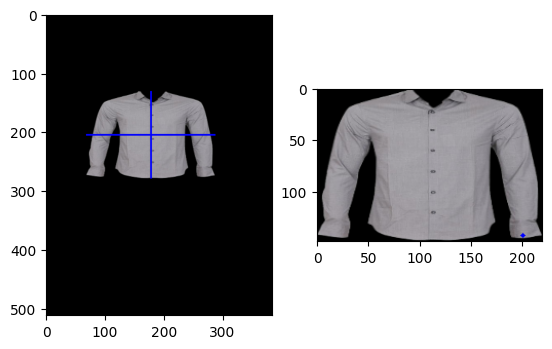

In [167]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(pts_img)

plt.show()

## Drag and Drop

In [173]:
import cv2
import numpy as np

def triangles(points):
    points = np.where(points, points, 1)
    subdiv = cv2.Subdiv2D((*points.min(0), *points.max(0)))
    for pt in points:
        subdiv.insert(tuple(map(int, pt)))
    for pts in subdiv.getTriangleList().reshape(-1, 3, 2):
        yield [np.where(np.all(points == pt, 1))[0][0] for pt in pts]

def crop(img, pts):
    x, y, w, h = cv2.boundingRect(pts)
    img_cropped = img[y: y + h, x: x + w]
    pts[:, 0] -= x
    pts[:, 1] -= y
    return img_cropped, pts

def warp(img1, img2, pts1, pts2):
    img2 = img2.copy()
    for indices in triangles(pts1):
        img1_cropped, triangle1 = crop(img1, pts1[indices])
        img2_cropped, triangle2 = crop(img2, pts2[indices])
        transform = cv2.getAffineTransform(np.float32(triangle1), np.float32(triangle2))
        img2_warped = cv2.warpAffine(img1_cropped, transform, img2_cropped.shape[:2][::-1], None, cv2.INTER_LINEAR, cv2.BORDER_REFLECT_101)
        mask = np.zeros_like(img2_cropped)
        cv2.fillConvexPoly(mask, np.int32(triangle2), (1, 1, 1), 16, 0)
        img2_cropped *= 1 - mask
        img2_cropped += img2_warped * mask
    return img2

def draw_circle(event, x, y, flags, param):
    pts = param
    if event == cv2.EVENT_LBUTTONDOWN:
        for pt in pts:
            dist = (pt[0] - x) ** 2 + (pt[1] - y) ** 2
            if dist < 225:
                active_pt[:] = pt
    elif event == cv2.EVENT_LBUTTONUP:
        active_pt[:] = 0
    elif event == cv2.EVENT_MOUSEMOVE:
        if np.any(active_pt):
            for pt in pts:
                if np.all(active_pt == pt):
                    pt[:] = active_pt[:] = x, y

def draw_circles(img, pts):
    img = img.copy()
    for i, (x, y) in enumerate(pts):
        cv2.circle(img, (x, y), 15, (0, 0, 255), -1)
        cv2.putText(img, str(i), (x - 10, y + 10), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 0, 0), 2)
    return img

def resize(img, size):
    h, w = img.shape[:2]
    return cv2.resize(img, (int(w * size), int(h * size)))

img1 = resize(cv2.imread("./data/align_shirt.png"), 0.8)
img2 = resize(cv2.imread("./data/osim.jpg"), 0.8)

pts_count = 10

pts1 = np.arange(pts_count * 2).reshape((pts_count, 2))
pts2 = np.arange(pts_count * 2).reshape((pts_count, 2))

active_pt = np.array([0, 0])

cv2.namedWindow("image 1")
cv2.setMouseCallback('image 1', draw_circle, pts1)
cv2.namedWindow("image 2")
cv2.setMouseCallback('image 2', draw_circle, pts2)
print(pts1)
print(type(pts1))
print(pts1.shape)
pause = False
while True:
    cv2.imshow('image 1', draw_circles(img1, pts1))
    cv2.imshow('image 2', draw_circles(img2, pts2))
    if not pause:
        try:
            cv2.imshow("result", warp(img1, img2, pts1, pts2))
        except:
            pass
    key = cv2.waitKey(20)
    if key & 0xFF == ord("q"):
        break
    if key & 0xFF == ord("p"):
        pause = not pause
    
cv2.waitKey(0)
cv2.destroyAllWindows()

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
<class 'numpy.ndarray'>
(10, 2)
